In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import copy
import cv2

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

from keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(50)

In [3]:
train_dir = "/kaggle/input/bangladeshi-crop-disease-dataset/Dataset/Train"
test_dir = "/kaggle/input/bangladeshi-crop-disease-dataset/Dataset/Test"
validation_dir ="/kaggle/input/bangladeshi-crop-disease-dataset/Dataset/Validation"

In [4]:
model1 = Xception(include_top=False,input_shape=(299, 299, 3), weights='imagenet')

83683744/83683744 [==============================] - 4s 0us/step


In [5]:
input_shape = (299,299)

In [6]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=False)


datagen_test = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)



batch_size = 32

generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

generator_val = datagen_val.flow_from_directory(directory=validation_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)


Found 9112 images belonging to 14 classes.
Found 2600 images belonging to 14 classes.
Found 1312 images belonging to 14 classes.


In [7]:
math.ceil(generator_train.samples)

9112

In [8]:
next(generator_train)[1]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0

In [9]:
conv_model = Model(inputs=model1.input, outputs=model1.output)

In [10]:
new_model = Sequential()
new_model.add(conv_model)
new_model.add(Flatten())
new_model.add(Dropout(0.5))
new_model.add(Dense(512, activation='relu'))
new_model.add(Dense(14, activation='softmax'))

In [11]:
tf. __version__

'2.12.0'

In [12]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

new_model.compile(optimizer= opt, loss=loss, metrics=metrics)

In [13]:
num_iters = 10000
num_batches_train = generator_train.n // batch_size

epochs = int(num_iters / num_batches_train)
print("Epoch: ",epochs)
desired_train_accuracy = 0.99

steps_per_epoch = generator_train.n // batch_size
steps_val = generator_val.n // batch_size
print("Steps_per_epoch: ",steps_per_epoch)
print("Steps_val: ",steps_val)

Epoch:  35
Steps_per_epoch:  284
Steps_val:  41


In [14]:
Checkpoint = ModelCheckpoint("Xception.hdf5", monitor="val_accuracy", save_best_only=True, mode="max")
EarlyStop = EarlyStopping(monitor="accuracy", baseline=desired_train_accuracy, patience=10, restore_best_weights=True, mode="auto")

history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  callbacks=[Checkpoint, EarlyStop],
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_val,
                                  validation_steps=steps_val)


/tmp/ipykernel_28/3741891571.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(generator=generator_train,


Epoch 1/35
284/284 [==============================] - 434s 1s/step - loss: 0.4377 - accuracy: 0.8622 - val_loss: 0.2094 - val_accuracy: 0.9245
Epoch 2/35
284/284 [==============================] - 315s 1s/step - loss: 0.1636 - accuracy: 0.9428 - val_loss: 0.1576 - val_accuracy: 0.9459
Epoch 3/35
284/284 [==============================] - 341s 1s/step - loss: 0.1129 - accuracy: 0.9641 - val_loss: 0.1643 - val_accuracy: 0.9543
Epoch 4/35
  5/284 [..............................] - ETA: 4:53 - loss: 0.0343 - accuracy: 0.9875

KeyboardInterrupt: 

In [15]:
new_model=tf.keras.models.load_model('Xception.hdf5')

In [16]:
Y_pred = new_model.predict(generator_test)
y_pred = np.argmax(Y_pred, axis=1)

82/82 [==============================] - 41s 497ms/step


In [17]:
class_labels = list(generator_test.class_indices.keys())

In [18]:
print(classification_report(generator_test.classes, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       238
           1       0.84      0.96      0.89       102
          10       1.00      1.00      1.00       200
          11       0.99      0.97      0.98       180
          12       0.99      1.00      0.99       223
          13       0.99      0.99      0.99       184
           2       0.99      1.00      0.99       232
           3       0.98      0.89      0.93       197
           4       1.00      0.99      1.00       200
           5       1.00      1.00      1.00        30
           6       1.00      1.00      1.00       200
           7       0.91      0.70      0.79       122
           8       0.83      0.97      0.89       297
           9       0.88      0.76      0.81       195

    accuracy                           0.95      2600
   macro avg       0.96      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



NameError: name 'history' is not defined

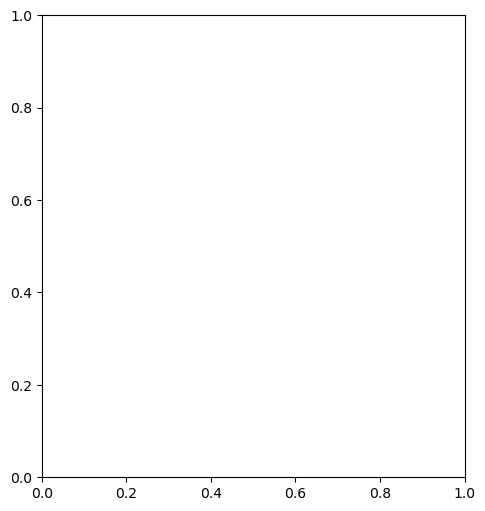

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.title("Accuracy")

plt.show()

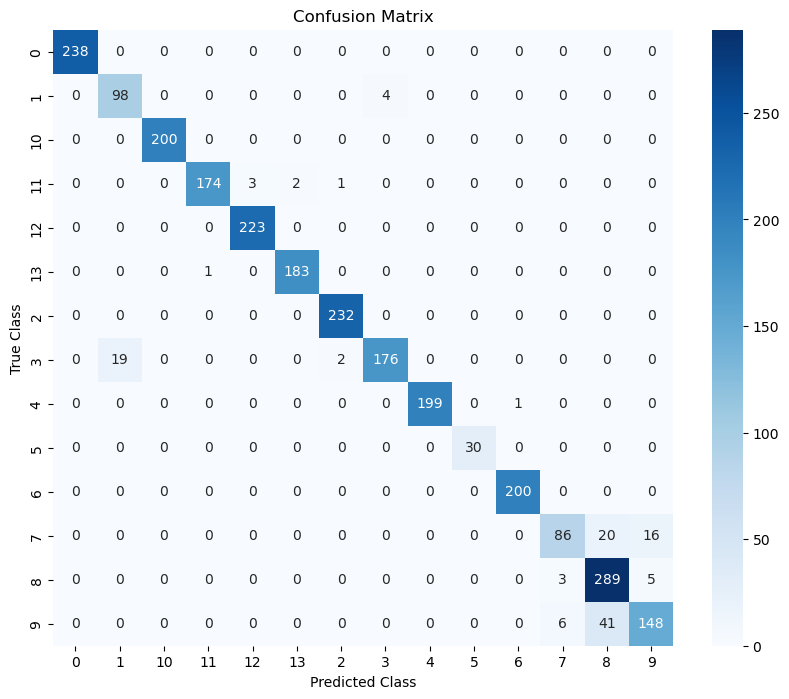

In [20]:
cm = confusion_matrix(generator_test.classes, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

In [69]:
image_path_show=[]
image_show=[]

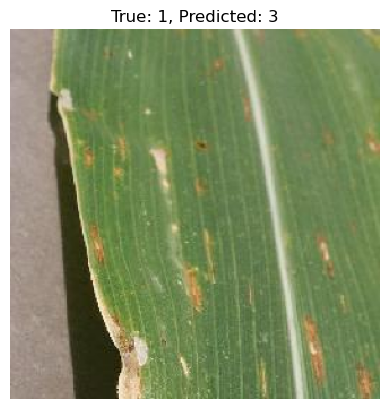

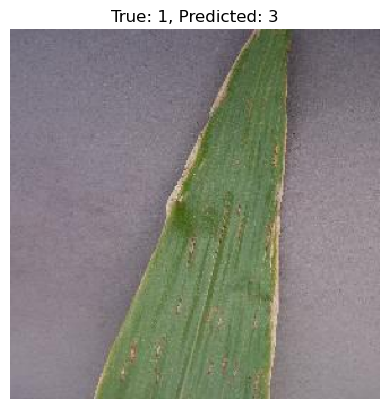

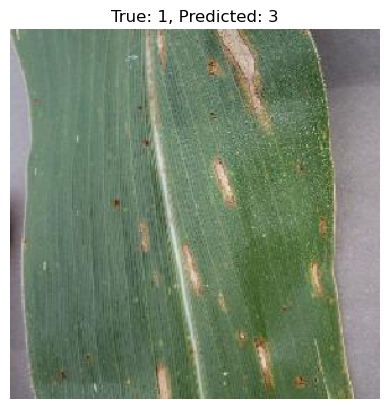

In [70]:
img_width, img_height= 299, 299
misclassified_images = []
for i in range(len(y_pred)):
    if y_pred[i] != generator_test.classes[i]:
        img_path = generator_test.filepaths[i]
        true_label = generator_test.classes[i]
        predicted_label = y_pred[i]
        misclassified_images.append((img_path, true_label, predicted_label))


num_display = 3
for img_path, true_label, predicted_label in misclassified_images[:num_display]:
    img = load_img(img_path, target_size=(img_width, img_height))
    plt.imshow(img)
    plt.title(f"True: {class_labels[true_label]}, Predicted: {class_labels[predicted_label]}")
    plt.axis('off')
    plt.show()
    
    image_path_show.append(img_path)
    image_show.append(img)

In [36]:
image_path_show
image_show

['/kaggle/input/bangladeshi-crop-disease-dataset/Dataset/Test/1/image (174).JPG',
 '/kaggle/input/bangladeshi-crop-disease-dataset/Dataset/Test/1/image (367).JPG',
 '/kaggle/input/bangladeshi-crop-disease-dataset/Dataset/Test/1/image (415).JPG']

# **XAI**

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

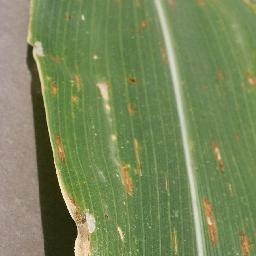

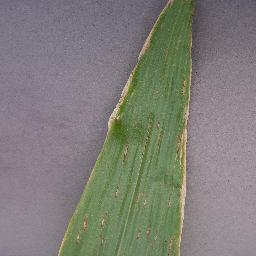

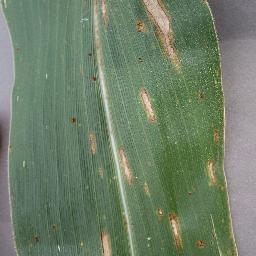

In [40]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

for path in image_path_show:
    img_path = path
    display(Image(img_path))

In [31]:
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [45]:
heatmaps=[]

1/1 [==============================] - 1s 1s/step
Predicted: [('n13133613', 'ear', 8.003904)]


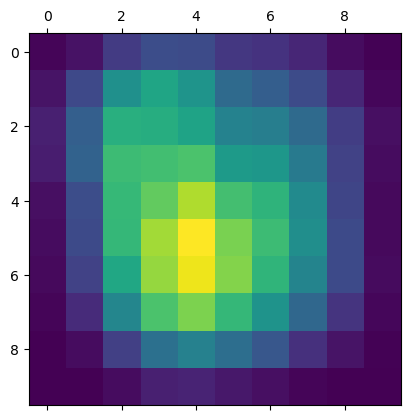

1/1 [==============================] - 1s 771ms/step
Predicted: [('n13133613', 'ear', 5.5592995)]


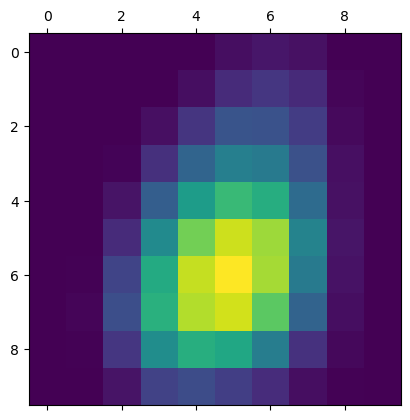

1/1 [==============================] - 1s 761ms/step
Predicted: [('n07716358', 'zucchini', 8.143272)]


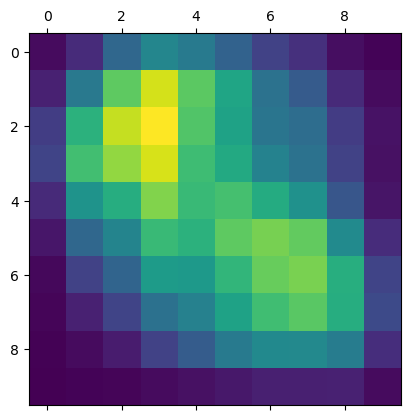

In [46]:
for img_path in image_path_show:
    img_array = preprocess_input(get_img_array(img_path, size=img_size))

    model = model_builder(weights="imagenet")
    model.layers[-1].activation = None

    preds = model.predict(img_array)
    print("Predicted:", decode_predictions(preds, top=1)[0])

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    heatmaps.append(heatmap)

    plt.matshow(heatmap)
    plt.show()

In [56]:
len(heatmaps)

3

/tmp/ipykernel_28/241504354.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


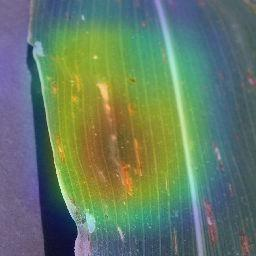

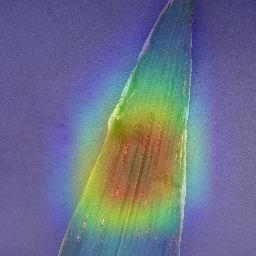

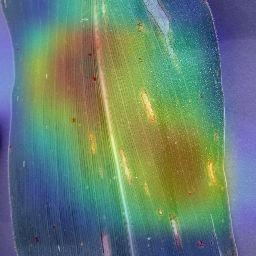

In [66]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)

    display(Image(cam_path))


for i in range(len(image_path_show)):
    img_path= image_path_show[i]
    heatmap= heatmaps[i]
    save_and_display_gradcam(img_path, heatmap)

# **LIME**